In [1]:
import matplotlib.pyplot as plt #Visulization
from matplotlib import rc # 한글 깨져서
import seaborn as sns #Visulization
import pandas as pd
import numpy as np

import scipy as sp
import scipy.stats

import datetime as dt
from dateutil.relativedelta import relativedelta

import tensorflow as tf

import statsmodels.api as sm

%matplotlib inline
plt.rc('font', family='Malgun Gothic')

In [2]:
df = pd.read_csv(r"C:\crop_data\1001kamis.csv")

In [3]:
df['yyyy'] = df['date'].map(lambda x: str(x)[0:4])
df['mm'] = df['date'].map(lambda x: str(x)[4:6])
df['dd'] = df['date'].map(lambda x: str(x)[6:8])

In [4]:
new_df = df[['avg','yyyy','mm']].groupby(['yyyy','mm']).mean()

c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\users\pc\appdata\local\programs\python\python37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


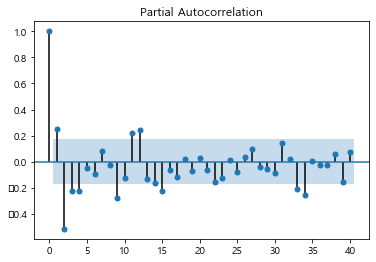

In [5]:
x_t  = new_df['avg'][1:]
x_t1 = new_df['avg'][:-1]
y = np.log(x_t.values / x_t1.values)
sm.graphics.tsa.plot_pacf(y, lags=40)
plt.show()

In [6]:
x_t1 = pd.Series(x_t1.values)
x_t = pd.Series(x_t.values)
x_t1.corr(x_t)

0.6519237575749499

In [7]:
mean_of_month = new_df

In [8]:
mean_of_month['kgperprice'] = mean_of_month['avg']

In [9]:
x_t  = mean_of_month['kgperprice'][4:]
x_t1 = mean_of_month['kgperprice'][3:-1]
x_t2 = mean_of_month['kgperprice'][2:-2]
x_t3 = mean_of_month['kgperprice'][1:-3]
x_t4 = mean_of_month['kgperprice'][:-4]

xi_t  = np.log(x_t.values  / x_t1.values)
xi_t1 = np.log(x_t1.values / x_t2.values)
xi_t2 = np.log(x_t2.values / x_t3.values)
xi_t3 = np.log(x_t3.values / x_t4.values)

x_train = np.c_[ xi_t1[:-38], xi_t2[:-38], xi_t3[:-38] ]
y_train = xi_t[:-38].reshape(-1,1)
x_test = np.c_[ xi_t1[90:], xi_t2[90:], xi_t3[90:] ]
y_test = xi_t[90:].reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(90, 3)
(90, 1)
(38, 3)
(38, 1)


In [10]:
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal([x_train.shape[1], 10]))
b1 = tf.Variable(tf.zeros([10]))
H1 = tf.nn.relu(tf.matmul(X, W1)+b1)

W2 = tf.Variable(tf.random_normal([10, 1]))
b2 = tf.Variable(tf.zeros([1]))
model = tf.matmul(H1, W2) + b2

In [11]:
cost = tf.reduce_mean(tf.square(model - Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(cost)

In [12]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for step in range(3000):
        _, cost_val = sess.run([train_op, cost], feed_dict={X: x_train, Y: y_train})
        if step % 1000 == 0: print("[step: {}	loss: {}]".format(step, cost_val))
    # 학습결과 확인
    predict = sess.run(model, feed_dict={X: x_test})
#     print("Y:", sess.run(model, feed_dict={X:x_test }))

[step: 0	loss: 0.5167848467826843]
[step: 1000	loss: 0.06152058765292168]
[step: 2000	loss: 0.05123506113886833]


In [13]:
compare_value = np.c_[y_test, predict]

# numppy array에 컬럼이름 주기
compare_value = {'실제값':compare_value[:,0], '예측값':compare_value[:,1]}

# Dataframe으로 만들기
compare_value = pd.DataFrame(compare_value)

compare_value['실제값_비율'] = -1
compare_value['예측값_비율'] = -1
compare_value['맞았니'] = ''

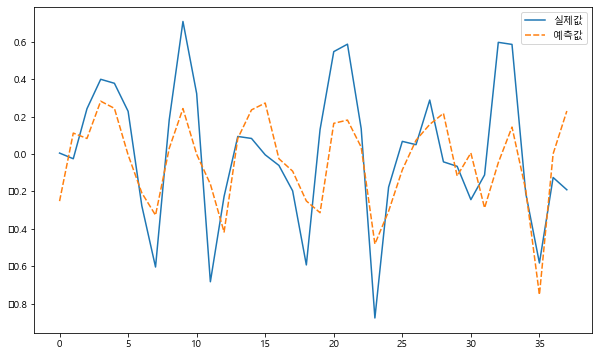

In [14]:
for i in range(len(compare_value)):
    if(compare_value.iloc[i,0] < 0):
        compare_value.iloc[i,2] = 0
    else: compare_value.iloc[i,2] = 1
    if(compare_value.iloc[i,1] < 0):
        compare_value.iloc[i,3] = 0
    else: compare_value.iloc[i,3] = 1

for i in range(len(compare_value)):
    if(compare_value.iloc[i,2] == compare_value.iloc[i,3]):
        compare_value.iloc[i,4] = 1
    else:
        compare_value.iloc[i,4] = 0

compare_value.iloc[:-1,4].sum() / (x_test.shape[0] - 1)

plt.figure(num=None, figsize=(10, 6))
sns.lineplot(data=compare_value.iloc[:,[0,1]])

In [15]:
compare_value.iloc[:-1,4].sum() / (x_test.shape[0] - 1)

0.7027027027027027